In [1]:
%pip install itables tqdm

import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sys import getsizeof
from tqdm import tqdm
from scipy.stats import entropy
from itertools import permutations


def safe_log2(x):
    return math.log2(x) if x > 0 else 0


def tuple_to_string(num_tuple):
    return ''.join(map(str, num_tuple))


def calculate_bulls_cows(source, target):
    if len(source) != len(target):
        raise ValueError("Input arrays must have the same length")

    bulls = sum(s == t for s, t in zip(source, target))
    common_digits = set(source) & set(target)
    cows = sum(min(source.count(digit), target.count(digit)) for digit in common_digits) - bulls

    return bulls, cows


def get_pattern_distribution_dict(originals, candidates):
    pattern_distribution_dict = {}
    for source in tqdm(originals):
        pattern_dist = {}
        for target in candidates:
            guess_result = calculate_bulls_cows(source, target)
            if tuple_to_string(guess_result) in pattern_dist:
                pattern_dist[tuple_to_string(guess_result)] += 1
            else:
                pattern_dist[tuple_to_string(guess_result)] = 1

        pattern_distribution_dict[source] = pattern_dist

    return pattern_distribution_dict


def calc_entropy_dict(originals, candidates):
    entropy_dict = {}
    pattern_distribution_dict = get_pattern_distribution_dict(originals, candidates)

    for candidate in pattern_distribution_dict:
        pattern_dist = pattern_distribution_dict[candidate]
        entropy_dict[candidate] = entropy(list(pattern_dist.values()), base=2)

    return sorted(entropy_dict.items(), key = lambda x: x[1], reverse=True)


class BullsNCows:
    def __init__(self, digits=4, random=True):
        permute = permutations([i for i in range(10)], digits)
        self.originals = [tuple_to_string(p) for p in list(permute)]
        self.digits = digits
        self.random = random


    def reset(self):
        self.attempts = 0
        self.secret = random.choice(self.originals)
        self.candidates = self.originals
        self.summary = [{
            "candidate_count": len(self.candidates),
            "candidate_entropy": safe_log2(len(self.candidates)),
        }]


    def next(self):
        if not self.random and self.attempts > 0:
            entropy_dict = calc_entropy_dict(self.originals, self.candidates)
            print(entropy_dict)
            guess, guess_entropy = entropy_dict[0]
        else:
            guess = random.choice(self.candidates)
            guess_entropy = np.NaN

        self.attempts += 1
        guess_result = calculate_bulls_cows(self.secret, guess)
        self.candidates = [c for c in self.candidates if calculate_bulls_cows(guess, c) == guess_result]
        self.summary.append({
            "guess": guess,
            "guess_result": guess_result,
            "guess_actual_entropy": self.summary[-1]['candidate_entropy']-safe_log2(len(self.candidates)),
            "guess_expect_entropy": guess_entropy,
            "candidate_count": len(self.candidates),
            "candidate_entropy": safe_log2(len(self.candidates)),
        })

        return self


    def play(self):
        self.reset()
        n_iter = 10
        while len(self.candidates) > 1 and n_iter > 0:
            self.next()
            n_iter -= 1

        return self.attempts, pd.DataFrame.from_dict(self.summary)


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
D = 3
game = BullsNCows(digits=D, random=False)

originals = game.originals
bulls_n_cows_map = {}

for i, _ in enumerate(originals):
    # bulls_n_cows_map[source] = {}
    bulls_n_cows_map[i] = {}
    for di in range(D+1):
        for dj in range(di+1):
           # bulls_n_cows_map[source][(dj, di-dj)] = set()
           bulls_n_cows_map[i][(dj, di-dj)] = set()

for i, source in tqdm(enumerate(originals), total=len(originals)):
    # bulls_n_cows_map[source][(D, 0)].add(source)
    bulls_n_cows_map[i][(D, 0)].add(i)
    for j in range(i):
        target = originals[j]
        bulls_n_cows = calculate_bulls_cows(source, target)
        # bulls_n_cows_map[source][bulls_n_cows].add(target)
        # bulls_n_cows_map[target][bulls_n_cows].add(source)
        bulls_n_cows_map[i][bulls_n_cows].add(j)
        bulls_n_cows_map[j][bulls_n_cows].add(i)

100%|██████████| 720/720 [00:00<00:00, 860.16it/s] 


In [5]:
with open(f'bulls_n_cows_map/{D}.pkl', 'wb') as f:
	pickle.dump(bulls_n_cows_map, f, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
_, df = BullsNCows(digits=3, random=False).play(); df

 16%|█▌        | 114/720 [00:00<00:00, 1137.11it/s]

100%|██████████| 720/720 [00:00<00:00, 1031.15it/s]


[('149', 2.358740005645094), ('159', 2.358740005645094), ('169', 2.358740005645094), ('179', 2.358740005645094), ('189', 2.358740005645094), ('453', 2.358740005645094), ('459', 2.358740005645094), ('463', 2.358740005645094), ('469', 2.358740005645094), ('473', 2.358740005645094), ('479', 2.358740005645094), ('483', 2.358740005645094), ('489', 2.358740005645094), ('563', 2.358740005645094), ('569', 2.358740005645094), ('573', 2.358740005645094), ('579', 2.358740005645094), ('583', 2.358740005645094), ('589', 2.358740005645094), ('673', 2.358740005645094), ('679', 2.358740005645094), ('683', 2.358740005645094), ('689', 2.358740005645094), ('783', 2.358740005645094), ('789', 2.358740005645094), ('013', 2.3587400056450933), ('024', 2.3587400056450933), ('025', 2.3587400056450933), ('026', 2.3587400056450933), ('027', 2.3587400056450933), ('028', 2.3587400056450933), ('049', 2.3587400056450933), ('059', 2.3587400056450933), ('069', 2.3587400056450933), ('079', 2.3587400056450933), ('089', 2

100%|██████████| 720/720 [00:00<00:00, 6031.61it/s]


[('403', 2.466542752164839), ('453', 2.466542752164839), ('463', 2.466542752164839), ('473', 2.466542752164839), ('483', 2.466542752164839), ('059', 2.433566230934527), ('069', 2.433566230934527), ('079', 2.433566230934527), ('089', 2.433566230934527), ('509', 2.433566230934527), ('569', 2.433566230934527), ('579', 2.433566230934527), ('589', 2.433566230934527), ('609', 2.433566230934527), ('659', 2.433566230934527), ('679', 2.433566230934527), ('689', 2.433566230934527), ('709', 2.433566230934527), ('759', 2.433566230934527), ('769', 2.433566230934527), ('789', 2.433566230934527), ('809', 2.433566230934527), ('859', 2.433566230934527), ('869', 2.433566230934527), ('879', 2.433566230934527), ('340', 2.419879075051286), ('345', 2.419879075051286), ('346', 2.419879075051286), ('347', 2.419879075051286), ('348', 2.419879075051286), ('409', 2.359268203577856), ('469', 2.359268203577856), ('479', 2.359268203577856), ('489', 2.359268203577856), ('459', 2.3592682035778556), ('039', 2.33780510

100%|██████████| 720/720 [00:00<00:00, 30114.37it/s]


[('156', 2.25), ('157', 2.25), ('158', 2.25), ('165', 2.25), ('167', 2.25), ('168', 2.25), ('175', 2.25), ('176', 2.25), ('178', 2.25), ('185', 2.25), ('186', 2.25), ('187', 2.25), ('506', 2.25), ('507', 2.25), ('508', 2.25), ('605', 2.25), ('607', 2.25), ('608', 2.25), ('705', 2.25), ('706', 2.25), ('708', 2.25), ('805', 2.25), ('806', 2.25), ('807', 2.25), ('560', 2.1556390622295667), ('561', 2.1556390622295667), ('563', 2.1556390622295667), ('569', 2.1556390622295667), ('570', 2.1556390622295667), ('571', 2.1556390622295667), ('573', 2.1556390622295667), ('579', 2.1556390622295667), ('580', 2.1556390622295667), ('581', 2.1556390622295667), ('583', 2.1556390622295667), ('589', 2.1556390622295667), ('650', 2.1556390622295667), ('651', 2.1556390622295667), ('653', 2.1556390622295667), ('659', 2.1556390622295667), ('670', 2.1556390622295667), ('671', 2.1556390622295667), ('673', 2.1556390622295667), ('679', 2.1556390622295667), ('680', 2.1556390622295667), ('681', 2.1556390622295667), (

100%|██████████| 720/720 [00:00<00:00, 133281.79it/s]


[('017', 1.0), ('018', 1.0), ('027', 1.0), ('028', 1.0), ('037', 1.0), ('038', 1.0), ('047', 1.0), ('048', 1.0), ('057', 1.0), ('058', 1.0), ('067', 1.0), ('068', 1.0), ('071', 1.0), ('072', 1.0), ('073', 1.0), ('074', 1.0), ('075', 1.0), ('076', 1.0), ('079', 1.0), ('081', 1.0), ('082', 1.0), ('083', 1.0), ('084', 1.0), ('085', 1.0), ('086', 1.0), ('089', 1.0), ('097', 1.0), ('098', 1.0), ('107', 1.0), ('108', 1.0), ('127', 1.0), ('128', 1.0), ('137', 1.0), ('138', 1.0), ('147', 1.0), ('148', 1.0), ('157', 1.0), ('158', 1.0), ('167', 1.0), ('168', 1.0), ('170', 1.0), ('172', 1.0), ('173', 1.0), ('174', 1.0), ('175', 1.0), ('176', 1.0), ('179', 1.0), ('180', 1.0), ('182', 1.0), ('183', 1.0), ('184', 1.0), ('185', 1.0), ('186', 1.0), ('189', 1.0), ('197', 1.0), ('198', 1.0), ('207', 1.0), ('208', 1.0), ('217', 1.0), ('218', 1.0), ('237', 1.0), ('238', 1.0), ('247', 1.0), ('248', 1.0), ('257', 1.0), ('258', 1.0), ('267', 1.0), ('268', 1.0), ('270', 1.0), ('271', 1.0), ('273', 1.0), ('274

,candidate_count,candidate_entropy,guess,guess_result,guess_actual_entropy,guess_expect_entropy
0,720,9.491853,NaN,NaN,NaN,NaN
1,252,7.977280,932,"(0, 1)",1.514573,NaN
2,45,5.491853,149,"(1, 0)",2.485427,2.358740
3,8,3.000000,403,"(1, 0)",2.491853,2.466543
4,2,1.000000,156,"(0, 0)",2.000000,2.250000
5,1,0.000000,017,"(0, 2)",1.000000,1.000000


In [8]:
# digits = 4

# for randomFlag in [True, False]:
#     game = BullsNCows(digits, random=randomFlag)
#     n_iter = 10
#     scores = [game.play()[0] for _ in tqdm(range(n_iter))]

#     plt.subplot(1, 2, int(randomFlag)+1)
#     plt.title(f'{digits} Digits - {n_iter} Iterations - {randomFlag} - {sum(scores) / len(scores)}')
#     plt.hist(scores, bins=np.arange(0, max(scores)+1), align='left')

# plt.tight_layout()
# plt.show()

In [11]:
_, df = BullsNCows(digits=4, random=False).play(); df

100%|██████████| 5040/5040 [01:04<00:00, 77.60it/s]


[('0134', 2.858864548290264), ('0136', 2.858864548290264), ('0137', 2.858864548290264), ('0143', 2.858864548290264), ('0236', 2.858864548290264), ('0237', 2.858864548290264), ('0263', 2.858864548290264), ('0273', 2.858864548290264), ('0324', 2.858864548290264), ('0326', 2.858864548290264), ('0327', 2.858864548290264), ('0346', 2.858864548290264), ('0347', 2.858864548290264), ('0367', 2.858864548290264), ('0376', 2.858864548290264), ('0423', 2.858864548290264), ('0467', 2.858864548290264), ('0476', 2.858864548290264), ('0647', 2.858864548290264), ('1235', 2.858864548290264), ('1239', 2.858864548290264), ('1245', 2.858864548290264), ('1249', 2.858864548290264), ('1265', 2.858864548290264), ('1269', 2.858864548290264), ('1275', 2.858864548290264), ('1279', 2.858864548290264), ('1283', 2.858864548290264), ('1284', 2.858864548290264), ('1286', 2.858864548290264), ('1287', 2.858864548290264), ('1293', 2.858864548290264), ('1294', 2.858864548290264), ('1296', 2.858864548290264), ('1297', 2.85

100%|██████████| 5040/5040 [00:15<00:00, 315.33it/s]


[('2913', 3.0851357245453386), ('2941', 3.0851357245453386), ('6913', 3.0851357245453386), ('6941', 3.0851357245453386), ('7913', 3.0851357245453386), ('7941', 3.0851357245453386), ('1649', 3.078183103537406), ('1749', 3.078183103537406), ('1693', 3.078183103537405), ('1793', 3.078183103537405), ('1249', 3.0781831035374045), ('1293', 3.0781831035374045), ('2391', 3.0744696741299884), ('2419', 3.0744696741299884), ('6391', 3.0744696741299884), ('6419', 3.0744696741299884), ('7391', 3.0744696741299884), ('7419', 3.0744696741299884), ('3291', 3.0742159636463855), ('3691', 3.0742159636463855), ('3791', 3.0742159636463855), ('4219', 3.0742159636463855), ('4619', 3.0742159636463855), ('4719', 3.0742159636463855), ('2813', 3.0700908668623748), ('6541', 3.0700908668623748), ('6813', 3.0700908668623748), ('7541', 3.0700908668623748), ('7813', 3.0700908668623748), ('2541', 3.070090866862374), ('3281', 3.0697725379730088), ('3681', 3.0697725379730088), ('3781', 3.0697725379730088), ('4215', 3.069

100%|██████████| 5040/5040 [00:03<00:00, 1423.76it/s]


[('1846', 3.3559407382300903), ('1847', 3.3559407382300903), ('6841', 3.333692821646634), ('7841', 3.3336928216466335), ('8641', 3.3233480389875436), ('8741', 3.3233480389875436), ('1546', 3.3168582901124806), ('1547', 3.3168582901124806), ('4681', 3.302711622648611), ('4781', 3.302711622648611), ('6541', 3.296427161350515), ('7541', 3.296427161350515), ('1645', 3.289468243723325), ('1745', 3.289468243723325), ('4561', 3.278461588198796), ('4571', 3.278461588198796), ('1486', 3.2637437549887287), ('1487', 3.2637437549887287), ('4861', 3.2631473752460582), ('4871', 3.2631473752460582), ('5741', 3.262833696968342), ('5641', 3.2628336969683414), ('1648', 3.26185148152434), ('1748', 3.26185148152434), ('1465', 3.2594014930959414), ('1475', 3.2594014930959414), ('6481', 3.2531008612337686), ('7481', 3.2531008612337686), ('4651', 3.247237068939944), ('4751', 3.247237068939944), ('1485', 3.2179870782701796), ('8461', 3.2156825877960618), ('8471', 3.2156825877960618), ('1845', 3.21501585003650

100%|██████████| 5040/5040 [00:00<00:00, 8640.12it/s]


[('4260', 3.0930692077718893), ('3602', 3.039148671903071), ('3620', 3.039148671903071), ('3260', 3.0391486719030705), ('4602', 3.0391486719030705), ('6302', 3.0391486719030705), ('6320', 3.0391486719030705), ('6402', 3.0391486719030705), ('4620', 2.9502120649147465), ('6420', 2.9502120649147465), ('7120', 2.896291529045928), ('7820', 2.896291529045928), ('7920', 2.896291529045928), ('1720', 2.8962915290459277), ('1760', 2.8962915290459277), ('2460', 2.8962915290459277), ('7160', 2.8962915290459277), ('7860', 2.8962915290459277), ('7960', 2.8962915290459277), ('8720', 2.8962915290459277), ('8760', 2.8962915290459277), ('9720', 2.8962915290459277), ('9760', 2.8962915290459277), ('1607', 2.8423709931771084), ('1670', 2.8423709931771084), ('2360', 2.8423709931771084), ('3206', 2.8423709931771084), ('3560', 2.8423709931771084), ('3605', 2.8423709931771084), ('3650', 2.8423709931771084), ('5360', 2.8423709931771084), ('6107', 2.8423709931771084), ('6170', 2.8423709931771084), ('6305', 2.842

100%|██████████| 5040/5040 [00:00<00:00, 58064.29it/s]


[('0312', 1.0), ('0314', 1.0), ('0315', 1.0), ('0316', 1.0), ('0317', 1.0), ('0318', 1.0), ('0319', 1.0), ('0321', 1.0), ('0324', 1.0), ('0325', 1.0), ('0326', 1.0), ('0327', 1.0), ('0328', 1.0), ('0329', 1.0), ('0341', 1.0), ('0342', 1.0), ('0345', 1.0), ('0346', 1.0), ('0347', 1.0), ('0348', 1.0), ('0349', 1.0), ('0351', 1.0), ('0352', 1.0), ('0354', 1.0), ('0356', 1.0), ('0357', 1.0), ('0358', 1.0), ('0359', 1.0), ('0361', 1.0), ('0362', 1.0), ('0364', 1.0), ('0365', 1.0), ('0367', 1.0), ('0368', 1.0), ('0369', 1.0), ('0371', 1.0), ('0372', 1.0), ('0374', 1.0), ('0375', 1.0), ('0376', 1.0), ('0378', 1.0), ('0379', 1.0), ('0381', 1.0), ('0382', 1.0), ('0384', 1.0), ('0385', 1.0), ('0386', 1.0), ('0387', 1.0), ('0389', 1.0), ('0391', 1.0), ('0392', 1.0), ('0394', 1.0), ('0395', 1.0), ('0396', 1.0), ('0397', 1.0), ('0398', 1.0), ('0712', 1.0), ('0713', 1.0), ('0714', 1.0), ('0715', 1.0), ('0716', 1.0), ('0718', 1.0), ('0719', 1.0), ('0721', 1.0), ('0723', 1.0), ('0724', 1.0), ('0725', 

,candidate_count,candidate_entropy,guess,guess_result,guess_actual_entropy,guess_expect_entropy
0,5040,12.299208,NaN,NaN,NaN,NaN
1,1440,10.491853,9058,"(0, 1)",1.807355,NaN
2,369,8.527477,0134,"(0, 2)",1.964376,2.858865
3,78,6.285402,2913,"(0, 1)",2.242075,3.085136
4,14,3.807355,1846,"(0, 1)",2.478047,3.355941
5,2,1.000000,4260,"(2, 0)",2.807355,3.093069
6,1,0.000000,0312,"(0, 2)",1.000000,1.000000


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


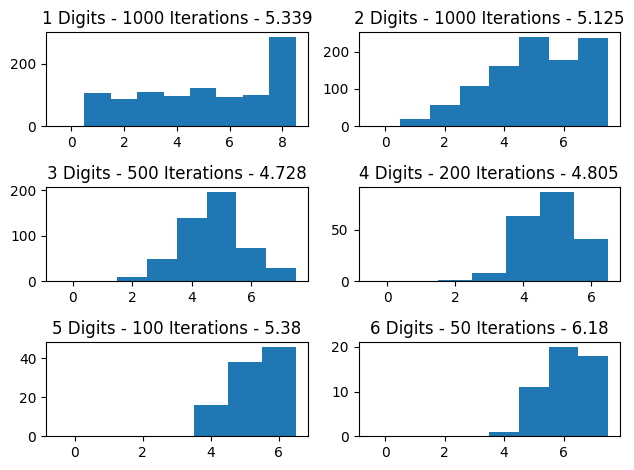

In [3]:
import matplotlib.pyplot as plt

MAX_DIGITS=6
iter_dict = {
    1: 1000,
    2: 1000,
    3: 500,
    4: 200,
    5: 100,
    6: 50,
}

for digits in range(1, MAX_DIGITS+1):
    game = BullsNCows(digits=digits, random=True)
    scores = [game.play()[0] for _ in tqdm(range(iter_dict[digits]))]

    plt.subplot((MAX_DIGITS+1)//2, 2, digits)
    plt.title(f'{digits} Digits - {iter_dict[digits]} Iterations - {sum(scores) / len(scores)}')
    plt.hist(scores, bins=np.arange(0, max(scores)+1), align='left')

plt.tight_layout()
plt.show()